**Run the following two cells before you begin.**

In [1]:
%autosave 10

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [3]:
# Import data set
df = pd.read_csv('cleaned_data.csv')


In [4]:
# Create features list

features = df[['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',  'PAY_AMT6']]
default = df['default payment next month']


_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [5]:
np.random.seed(24)
train_x, test_x, train_y, test_y = train_test_split(features.values, default.values, test_size=0.2) 

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [6]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)


_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [7]:
log_reg = LogisticRegression(penalty='l1', solver='saga', max_iter=1000000)
log_reg.fit(train_x, train_y)


LogisticRegression(max_iter=1000000, penalty='l1', solver='saga')

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [8]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('model', LogisticRegression())])
pipe.fit(train_x, train_y)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [9]:
# Use `get_params`
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('model', LogisticRegression())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': None,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [10]:
# View what `model__C` is set to currently
pipe.get_params()['model__C']

1.0

In [11]:
# Change `model__C` to 2
pipe.set_params(model__C=2)

pipe.get_params()['model__C']

2

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [12]:
C_vals = [10**2, 10, 1, 10**(-1), 10**(-2), 10**(-3)]

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [13]:
k_folds = StratifiedKFold(n_splits=4, random_state=1)

c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [14]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    for i in range(len(C_vals)):
        #Set the C value for the model object
        #pipeline.C = C_vals[i]
        pipeline.set_params(model__C = C_vals[i])
        #Count folds for each value of C
        fold = 0
        for train_index, test_index in k_folds.split(X, Y):
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            pipeline.fit(X_cv_train, y_cv_train)
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold, i] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold, i] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[i].append(this_fold_roc)
            fold += 1
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [15]:
from sklearn.datasets import make_classification
new_x, new_y = make_classification(n_samples=1000, n_features=200, n_informative=3, n_redundant=10, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=0.8, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=24)
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=24)
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, pipe, new_x_train, new_y_train)
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Done with C = 100


c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Done with C = 10


c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Done with C = 1
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


(array([[0.9805    , 0.97216667, 0.95472222, 0.92364444, 0.9013    ,
         0.89561111],
        [0.96678889, 0.96298889, 0.95016667, 0.92635556, 0.90882222,
         0.90552222],
        [0.97007778, 0.96376667, 0.94937778, 0.9251    , 0.90905556,
         0.90542222],
        [0.96208889, 0.95856667, 0.944     , 0.91346667, 0.88928889,
         0.88351111]]),
 array([[0.7386, 0.7705, 0.8321, 0.873 , 0.8798, 0.8798],
        [0.7675, 0.7853, 0.8226, 0.849 , 0.8554, 0.8551],
        [0.7687, 0.8003, 0.8372, 0.8481, 0.8476, 0.8482],
        [0.8119, 0.8319, 0.8706, 0.8981, 0.8956, 0.8921]]),
 [[(array([0.  , 0.  , 0.  , 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04,
           0.05, 0.05, 0.07, 0.07, 0.08, 0.08, 0.1 , 0.1 , 0.12, 0.12, 0.13,
           0.13, 0.14, 0.14, 0.18, 0.18, 0.2 , 0.2 , 0.21, 0.21, 0.23, 0.23,
           0.25, 0.25, 0.26, 0.26, 0.27, 0.27, 0.28, 0.28, 0.29, 0.29, 0.3 ,
           0.3 , 0.33, 0.33, 0.36, 0.36, 0.4 , 0.4 , 0.41, 0.41, 0.42, 0.42,
           0.43

_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

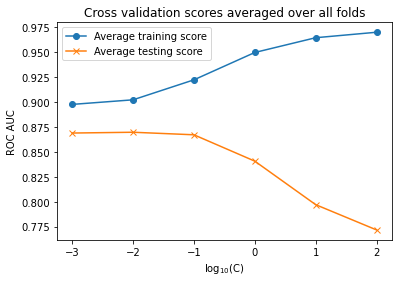

In [16]:
log_C_vals = np.log10(C_vals)
plt.plot(log_C_vals, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(log_C_vals, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [26]:
#features_cols = features.columns
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
x_interactions = poly_reg.fit_transform(features.values)

minmax = MinMaxScaler()

lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)

new_pipe = Pipeline(steps=[('scaler', minmax), ('model', lr)])

new_pipe.get_params()

new_pipe.set_params(model__C= 2)

new_pipe.get_params()['model__C']

C_vals, log_C_vals

([100, 10, 1, 0.1, 0.01, 0.001], array([ 2.,  1.,  0., -1., -2., -3.]))

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [27]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
np.random.seed(24)
X_train, X_test,Y_train, Y_test = train_test_split(x_interactions, default.values, test_size=0.2)


In [28]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, new_pipe, X_train, Y_train)
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Conv

Done with C = 100


c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Conv

Done with C = 10


c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mithlesh kawadkar\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


(array([[0.76022058, 0.75831781, 0.74696154, 0.72332592, 0.71889923,
         0.5       ],
        [0.76093073, 0.75939938, 0.7511166 , 0.7230791 , 0.71598412,
         0.5       ],
        [0.7508944 , 0.74909856, 0.73922922, 0.71538615, 0.71071684,
         0.5       ],
        [0.75661527, 0.75553766, 0.74732363, 0.72325359, 0.72051993,
         0.5       ]]),
 array([[0.73743857, 0.73777385, 0.73380766, 0.71352854, 0.71022845,
         0.5       ],
        [0.73925088, 0.73894561, 0.73655462, 0.72155118, 0.7179147 ,
         0.5       ],
        [0.76375592, 0.76354395, 0.75922139, 0.73830943, 0.73367926,
         0.5       ],
        [0.74164281, 0.74154801, 0.7353694 , 0.70881524, 0.70446   ,
         0.5       ]]),
 [[(array([0.00000000e+00, 0.00000000e+00, 2.41370987e-04, ...,
           9.97827661e-01, 9.97827661e-01, 1.00000000e+00]),
    array([0.00000000e+00, 8.40336134e-04, 8.40336134e-04, ...,
           9.99159664e-01, 1.00000000e+00, 1.00000000e+00]),
    array([2.00000

Text(0.5, 1.0, 'Cross validation on Case Study problem')

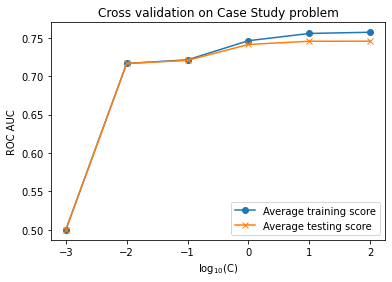

In [29]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.plot(log_C_vals, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(log_C_vals, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**